In [1]:
# import all modules 
import pandas as pd 
import numpy as np 
import sqlite3 
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from Tools.conversation import start_end_customers_filter
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. connect to the database 

In [2]:
con = sqlite3.connect('../../database/database(620).db')

In [3]:
query1 = """
    SELECT c.id_1, c.id_2, c.id_3, c.id_4, c.id_5, c.id_6, c.id_7, 
    c.airline_id, c.airline_name, c.conversation_opener, g.timestamp_ms
    FROM conversation as c, general_tweets as g
    WHERE g.id == c.id_1
"""
df = pd.read_sql_query(query1, con)

#### 2. get sentiment score 

In [4]:
query2 = "SELECT id, sentiment_score FROM sentiment_table"
df_sentiment = pd.read_sql_query(query2, con)

In [5]:
df = pd.concat([start_end_customers_filter(df), 
                df[['conversation_opener', 'timestamp_ms', 'airline_id', 'airline_name']].reset_index(drop=True)], 
               axis=1)

In [6]:
# fix the datatype
df['timestamp_ms'] = pd.to_datetime(df.timestamp_ms)
df_sentiment = df_sentiment.astype({
    'sentiment_score' : 'float64'
})

In [7]:
# get the sentiment score for open
df = df.merge(df_sentiment, left_on='open', right_on='id').drop(columns='id')
df.shape

(63707, 7)

In [8]:
# get the sentiment score for close 
df = df.merge(df_sentiment, left_on='close', right_on='id', suffixes=('_open', '_close')).drop(columns='id')
df.shape

(62015, 8)

In [9]:
df['sentiment_change'] = df['sentiment_score_close'] - df['sentiment_score_open']

In [10]:
df['positive'] = df['sentiment_change'] > 0

In [11]:
all_df = df.copy()

#### 3. filter by timestamps (depend on teacher)

In [12]:
# add attributes month and year 
month = []
year = []
for idx, row in all_df.iterrows():
    month.append(row.timestamp_ms.month)
    year.append(row.timestamp_ms.year)
all_df['month'] = month
all_df['year'] = year

In [13]:
all_df.groupby(['year', 'month']).count().index

MultiIndex([(2019,  5),
            (2019,  6),
            (2019,  7),
            (2019,  8),
            (2019,  9),
            (2019, 10),
            (2019, 11),
            (2019, 12),
            (2020,  1),
            (2020,  2),
            (2020,  3)],
           names=['year', 'month'])

In [17]:
# example teacher on 9 and 9 of 2019
n_month = [9, 10]
n_year = 2019
df = all_df[(all_df.month.isin(n_month)) & (all_df.year==n_year)].copy()
df.shape

(9636, 12)

#### 4. Plotting 

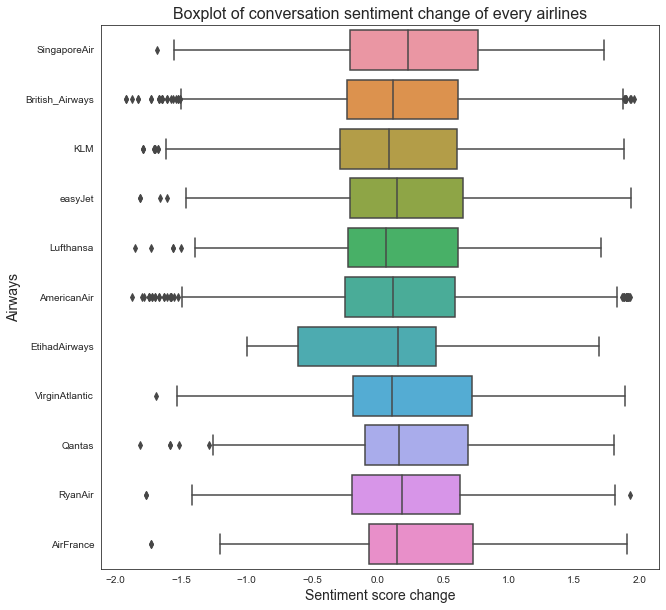

In [19]:
# boxplot for every airlines
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df, x='sentiment_change' ,y='airline_name', orient='h', ax=ax)
ax.set_title('Boxplot of conversation sentiment change of every airlines', size=16)
ax.set_ylabel('Airways', size=14)
ax.set_xlabel('Sentiment score change', size=14)
ax.get_figure().savefig('boxplot for every airlines.png')

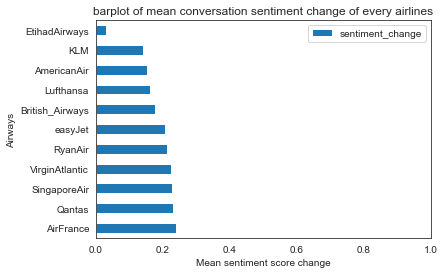

In [20]:
# barplot for mean
mean_df = df[['airline_name', 'sentiment_change']].groupby('airline_name').mean().sort_values(by='sentiment_change', 
                                                                                              ascending=False)
ax = mean_df.plot(kind='barh')
ax.set_xlim(0, 1)
ax.set_title('barplot of mean conversation sentiment change of every airlines', size=12)
ax.set_ylabel('Airways', size=10)
ax.set_xlabel('Mean sentiment score change', size=10);

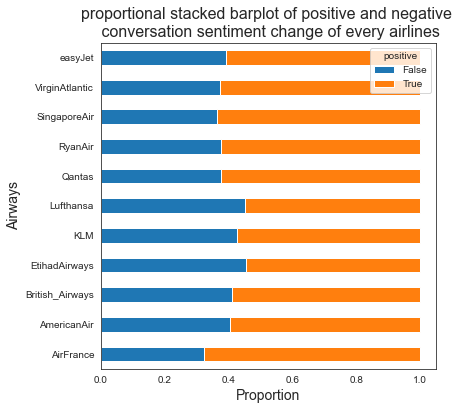

In [22]:
# do the proportional barplot
pro_df = df[['airline_name', 'positive']]
cross_tab_prop = pd.crosstab(index=pro_df['airline_name'],
                             columns=pro_df['positive'],
                             normalize="index")
ax = cross_tab_prop.plot(kind='barh', 
                    stacked=True,  
                    figsize=(6, 6))
ax.set_title('proportional stacked barplot of positive and negative \n conversation sentiment change of every airlines', size=16)
ax.set_ylabel('Airways', size=14)
ax.set_xlabel('Proportion', size=14)
ax.get_figure().savefig('proportional stacked barplot.svg', format='svg')